In [1]:
import io
from typing import Any, Dict, List, OrderedDict, Union
import os
from os.path import join as osj
import cv2
import decord
import matplotlib
import matplotlib.pyplot as plt
import moviepy.editor as mpy
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib.collections import LineCollection
import random
import pandas as pd
from workoutdetector.datasets import FrameDataset, build_test_transform, RepcountHelper
from workoutdetector.utils import plot_all, plt_params, plot_per_action
from matplotlib import font_manager
import json

matplotlib.RcParams.update(plt_params())
font_path = '/mnt/c/Users/Me/AppData/Local/Microsoft/Windows/Fonts/Cairo-VariableFont_wght.ttf'
font_manager.fontManager.addfont(font_path)
font_manager.findSystemFonts(fontext='otf')
fe = font_manager.FontEntry(fname=font_path, name='Cairo')
font_manager.fontManager.ttflist.insert(0, fe) 
matplotlib.rcParams.update(plt_params())
matplotlib.rcParams['font.family'] = 'Cairo'

In [2]:
data_root = os.path.expanduser("~/data/RepCount")
anno_path = osj(data_root, "annotation.csv")
helper = RepcountHelper(data_root, anno_path)
CLASSES = helper.classes
print(CLASSES)
data = list(helper.get_rep_data(['train', 'val', 'test'], ['all']).values())
item = random.choice(data)
print(item)

['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']
video: test2025.mp4
class: situp
count: 5
reps: [0, 49, 49, 106, 106, 162, 162, 210, 210, 266]
fps: 30.0


In [3]:
json_dir = os.path.expanduser('~/projects/WorkoutDetector/out/acc_0.841_epoch_26_20220711-191616_1x1')
json_files = os.listdir(json_dir)
template  = '{}.stride_1_step_1.json'
print(len(json_files))
print(json_files[0])
print(json.load(open(osj(json_dir, json_files[0]))).keys())

762
stu7_51.mp4.stride_1_step_1.json
dict_keys(['video_name', 'model', 'stride', 'step', 'length', 'fps', 'input_shape', 'checkpoint', 'total_frames', 'ground_truth', 'action', 'scores'])


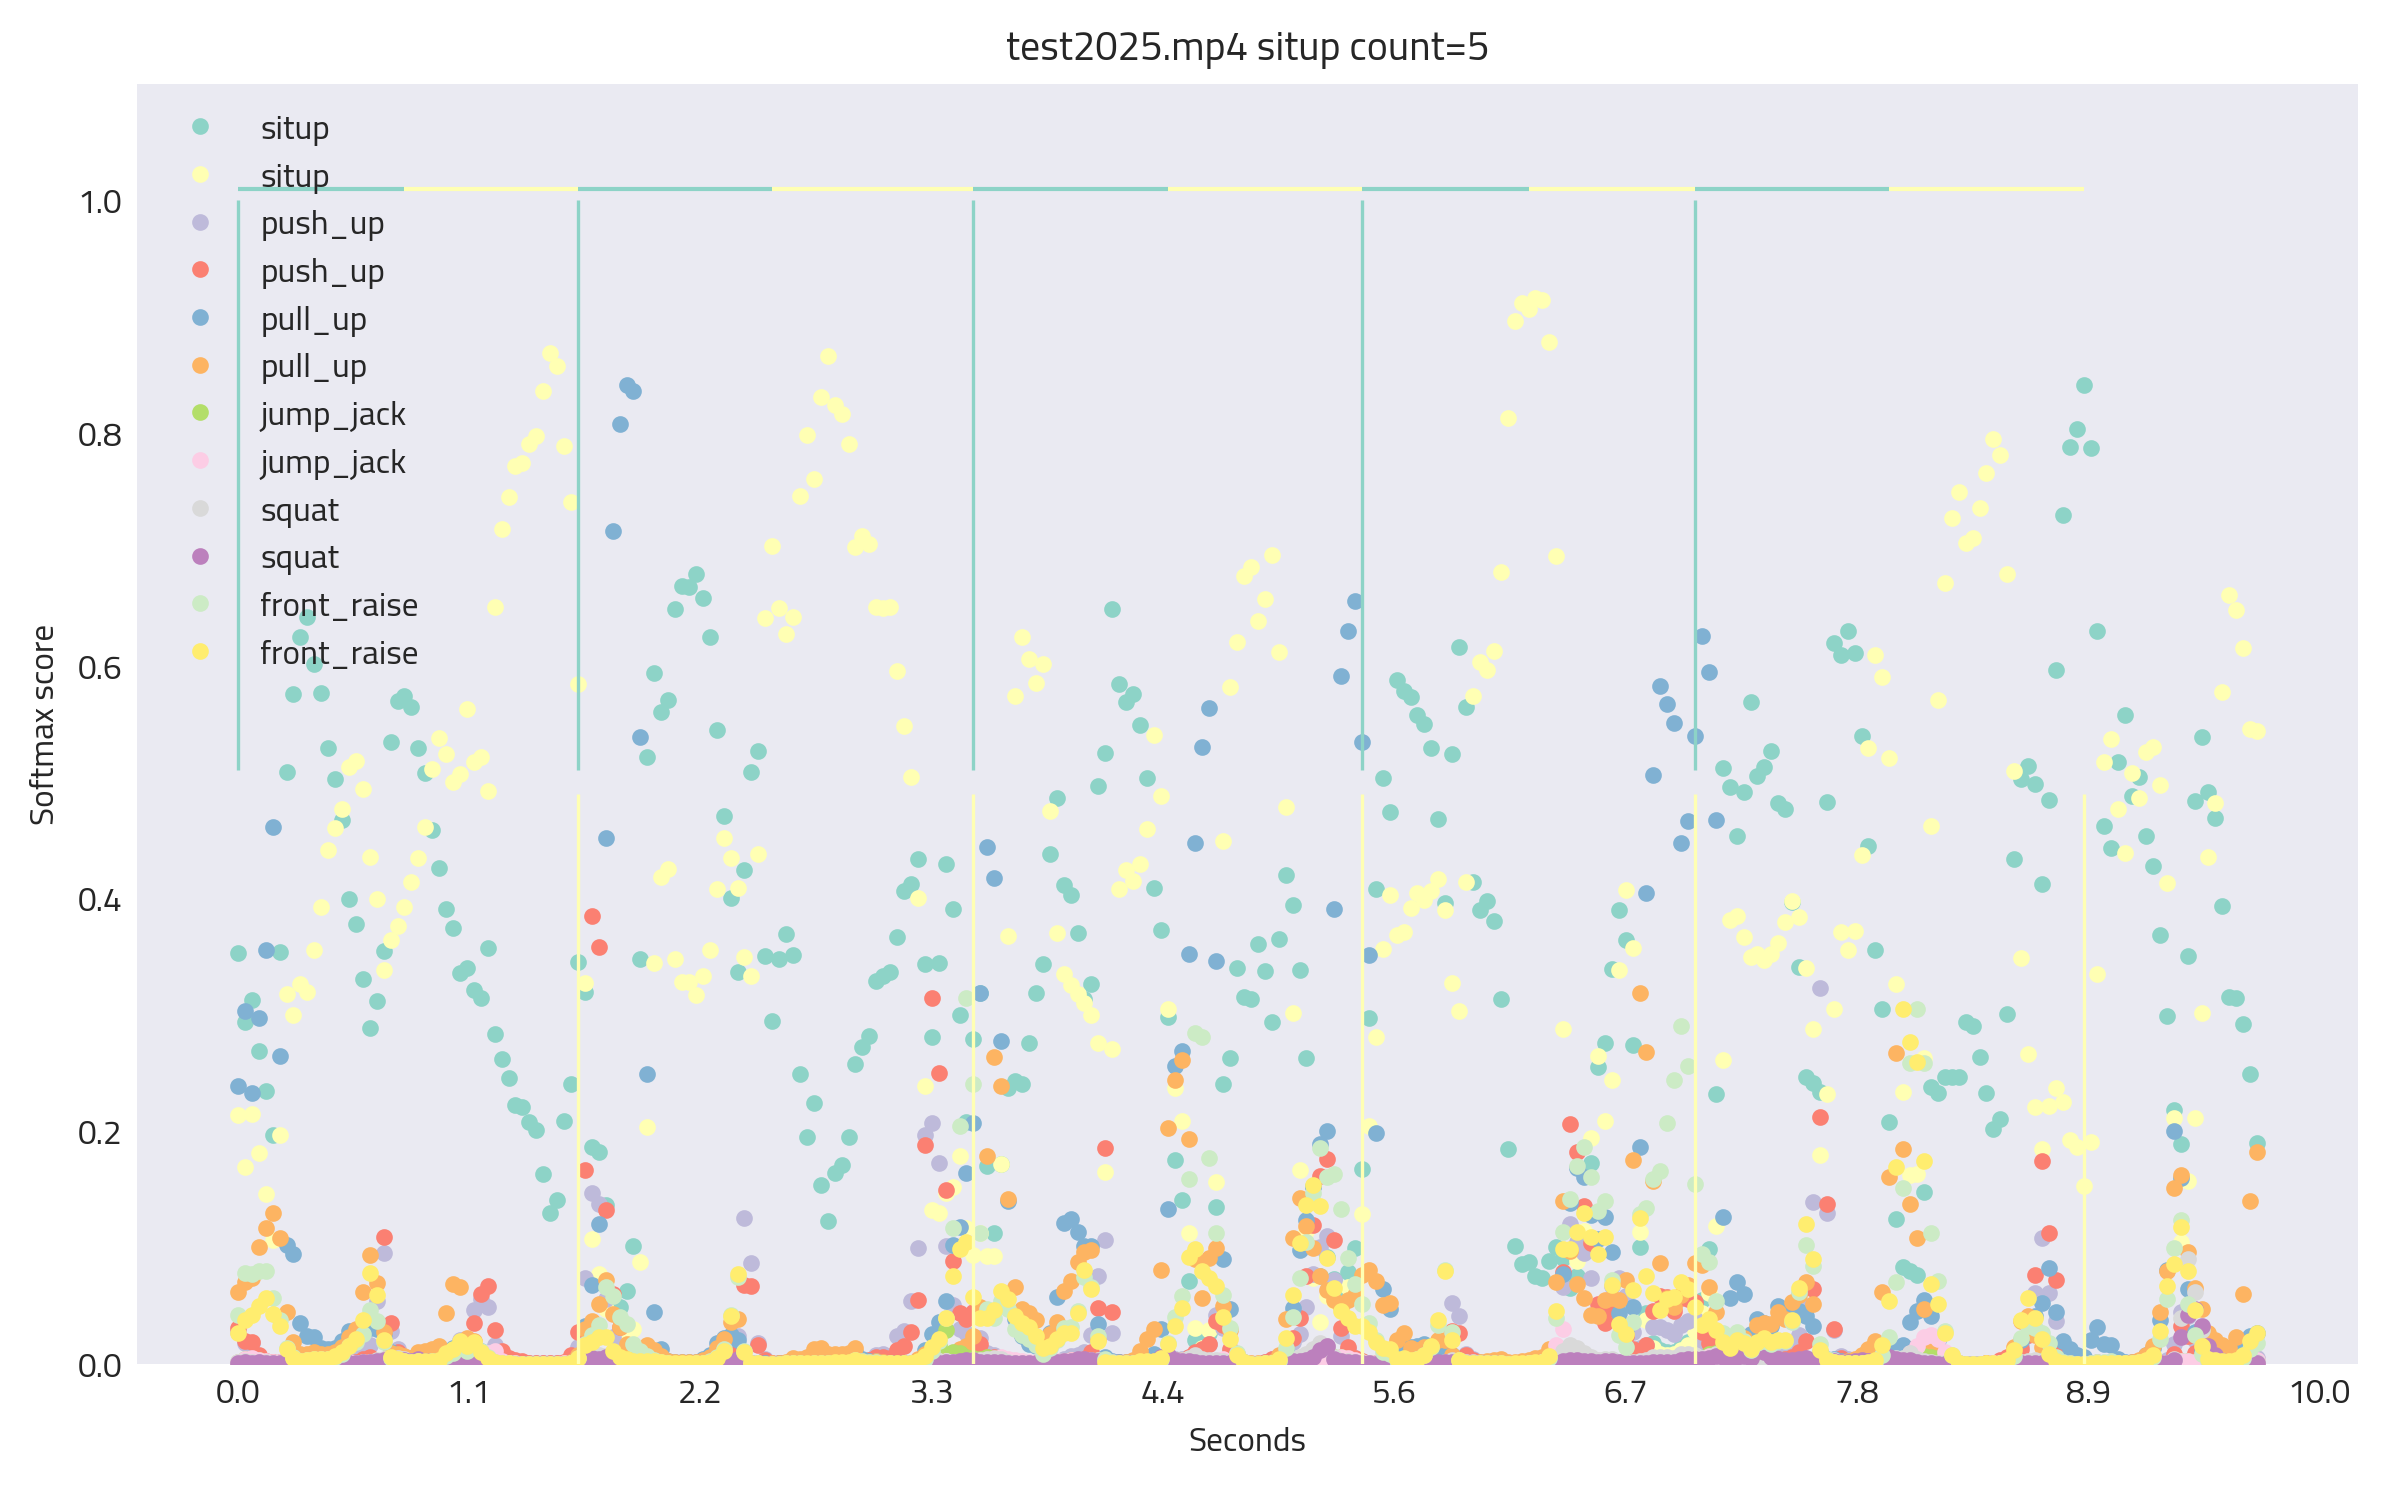

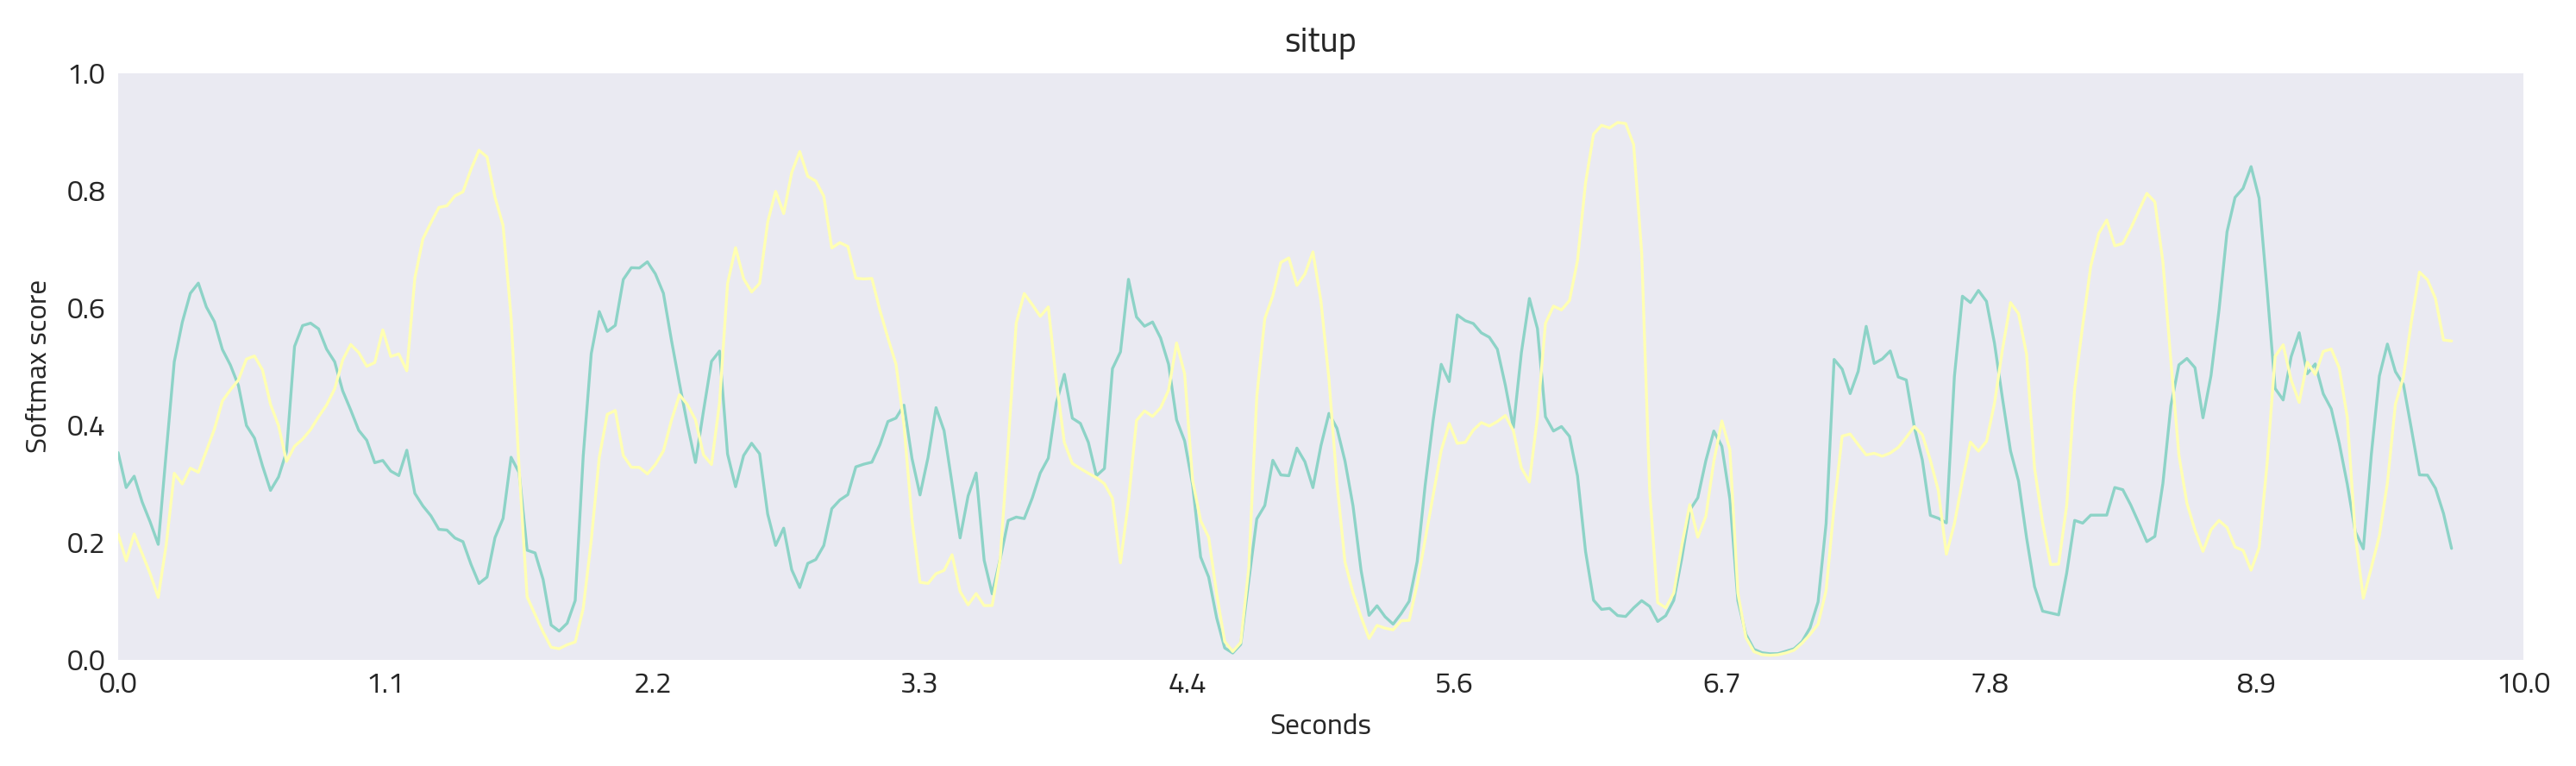

In [4]:
js = json.load(open(osj(json_dir, template.format(item.video_name))))

plot_all(js['ground_truth'], js, softmax=True, stride=1)
plot_per_action(js, softmax=True, action_only=True)

## Hidden Markov Model

- Input: a sequence of probabilities of shape (seq_len, 12)
- Output: a float

In [5]:
from hmmlearn import hmm
from collections import Counter

In [6]:
def reps_to_label(reps, total, classname):
    class_idx = CLASSES.index(classname)
    y = [0] * total
    for start, end in zip(reps[::2], reps[1::2]):
        mid = (start + end) // 2
        y[start:mid] = [class_idx*2+1] * (mid - start)
        y[mid:end] = [class_idx*2+2] * (end - mid) # plus 1 because no-class is 0
    return y

def load_data(split, action):
    data = list(helper.get_rep_data([split], [action]).values())
    x = [] # classification probabilities
    y = [] # labels + 1 no-class = 13 classes
    for item in data:
        js = json.load(open(osj(json_dir, template.format(item.video_name))))
        for i,v in js['scores'].items():
            x.append(np.array(list(v.values())))
        start_ids = list(map(int, list(js['scores'].keys())))
        y += reps_to_label(item.reps, item.total_frames, item.class_)[7:7+len(start_ids)]
    x = np.array(x)
    return x, y

train_x, train_y = load_data('train', 'squat')
print(train_x.shape, len(train_y))
# stats
counter = Counter(train_y)
print(counter)
startprob = np.zeros(13)
for i in range(13):
    startprob[i] = counter[i] / len(train_y)

transmat = np.ones((13, 13)) * 1/13
assert np.allclose(transmat.sum(axis=0), 1)

means = np.zeros((13, 13, 2))
covars = np.tile(np.identity(2), (13, 1, 1))


(87573, 12) 87573
Counter({10: 34854, 9: 34169, 0: 18550})


In [101]:
model = hmm.GaussianHMM(n_components=13, n_iter=300, covariance_type='full', verbose=True)
model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars
model.fit(train_x)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
         1    -1250330.7520             +nan
         2     -788599.3274     +461731.4246
         3     -563217.8380     +225381.4894
         4     -468917.3578      +94300.4801
         5     -422073.4539      +46843.9039
         6     -394031.2425      +28042.2114
         7     -367037.4881      +26993.7545
         8     -344281.7077      +22755.7804
         9     -309118.6749      +35163.0328
        10     -248350.1010      +60768.5739
        11     -157224.8966      +91125.2044
     

GaussianHMM(covariance_type='full', n_components=13, n_iter=300, verbose=True)

(712, 12) 712
712
[ 9 12 12 12 12 12 12 12 12 12 12 12  5  5  5  5  5  5  5 12 12 12 12 12
 12 12 12 12 12 12]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
count 9
acc 0.033707865168539325


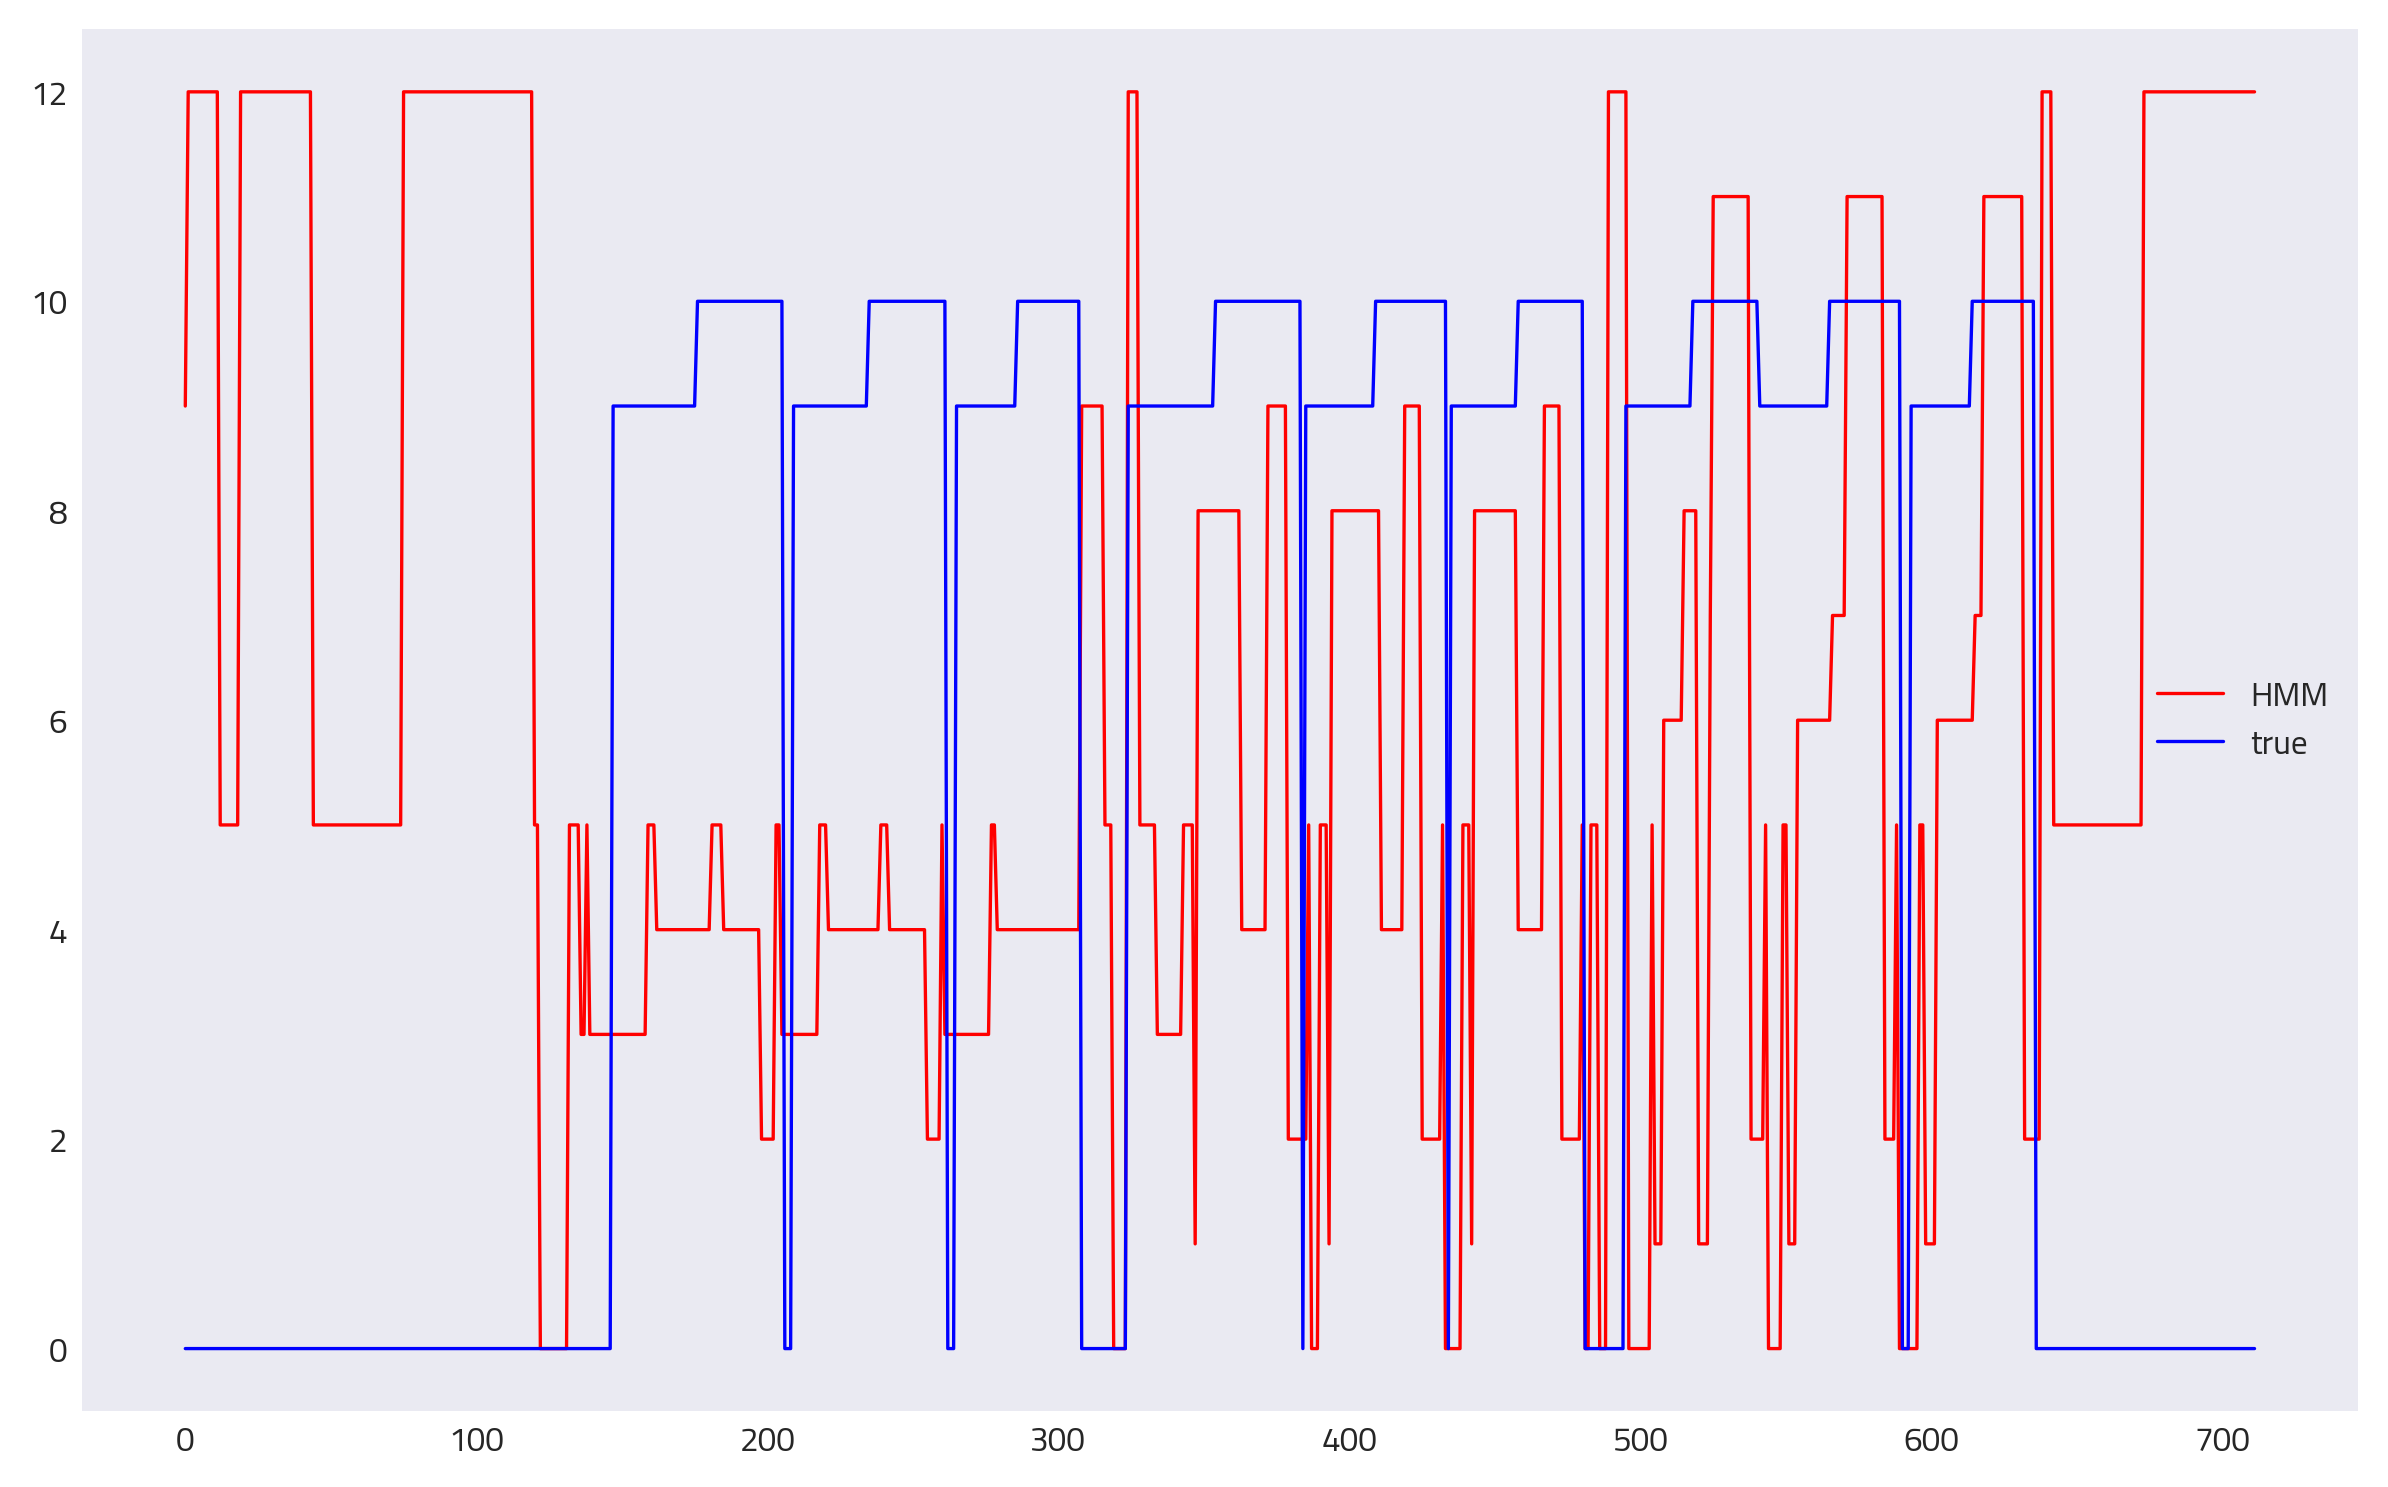

In [106]:
val_data = list(helper.get_rep_data(['val'], ['squat']).values())
item = random.choice(val_data)
val_x = []
js = json.load(open(osj(json_dir, template.format(item.video_name))))
for i,v in js['scores'].items():
    val_x.append(np.array(list(v.values())))
val_x = np.array(val_x)
val_y = reps_to_label(item.reps, item.total_frames, item.class_)[7:7+len(val_x)]
val_y = np.array(val_y)
print(val_x.shape, len(val_y))

pred = model.predict(val_x)
print(len(pred))
print(pred[:30])
print(val_y[:30])
print('count', len(js['ground_truth'])//2)

acc = (pred == val_y).mean()
print('acc', acc)

plt.plot(pred, 'r', label='HMM')
plt.plot(val_y, 'b', label='true')
plt.legend()
plt.show()

## MLP

In [30]:
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        return self.layers(x)

window = 10
model_mlp = MLP(12*window, 100, 13)

In [34]:
train_x, train_y = [], []
for item in data:
    x, y = [], []
    js = json.load(open(osj(json_dir, template.format(item.video_name))))
    for i,v in js['scores'].items():
        x.append(np.array(list(v.values())))
    y = reps_to_label(item.reps, item.total_frames, item.class_)
    x, y = torch.Tensor(x), torch.Tensor(y)
    n = len(x) - window + 1
    for i in range(n):
        train_x.append(x[i:i+window])
        train_y.append(y[7+i])

print(len(train_x), len(train_y))
print(train_x[0].shape, train_y[0])

optimizer = torch.optim.Adam(model_mlp.parameters(), lr=1e-4)
loader = zip(train_x, train_y)
model_mlp.to('cuda')
train_x = torch.stack(train_x).to('cuda')
train_y = torch.stack(train_y).to('cuda')

class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x.flatten(start_dim=1)
        self.y = y
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return len(self.x)
    
loader = DataLoader(Dataset(train_x, train_y), batch_size=64, shuffle=True)

for _ in range(10):
    model_mlp.train()
    model_mlp.zero_grad()
    train_loss = 0
    for x, y in loader:
        output = model_mlp(x)
        loss = F.cross_entropy(output, y.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(loader)
    print('train loss', train_loss)

    model_mlp.eval()
    val_loss = 0
    val_acc = 0
    for x, y in loader:
        output = model_mlp(x)
        loss = F.cross_entropy(output, y.long())
        val_loss += loss.item()
        val_acc += (output.argmax(dim=1) == y).sum().item()
    val_loss /= len(loader)
    val_acc /= len(train_x)
    print('val loss', val_loss)
    print('val acc', val_acc)

        

640141 640141
torch.Size([10, 12]) tensor(11.)
train loss 2.4384307279761264
val loss 2.4383802693044854
val acc 0.2361276656236673
train loss 2.438567874122474
val loss 2.438633342820335
val acc 0.2361276656236673
train loss 2.438267791985059
val loss 2.438528247419672
val acc 0.2361276656236673
train loss 2.43849461197579
val loss 2.4385885188642247
val acc 0.2361276656236673
train loss 2.438400938309968
val loss 2.4387642166727272
val acc 0.2361276656236673
train loss 2.4385698175806887
val loss 2.4388649465321994
val acc 0.2361276656236673
train loss 2.438571684815509
val loss 2.439886988228254
val acc 0.2361276656236673
train loss 2.4386714286808013
val loss 2.4390648129247827
val acc 0.2361276656236673
train loss 2.4385279180478494
val loss 2.4388276929320494
val acc 0.2361276656236673
train loss 2.4386694519255
val loss 2.4384416869362866
val acc 0.2361276656236673


## LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.layers = nn.Sequential(
            nn.LSTM(input_size, hidden_size, batch_first=True),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        return self.layers(x)